In [18]:
import nbsetup
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from helpers.ergodic import ErgodicEnsemble

In [509]:
MAX = 20
ENSEMBLES = 2
BIN_RANGE = [3, 5, 7, 10]
OBS_RANGE = [50, 100, 200, 500, 800, 1000, 1500, 2000]

CASES = {
    "power 2": lambda i, o: np.random.power(2,o)*MAX,
    "power 4": lambda i, o: np.random.power(4,o)*MAX,
    "power 6": lambda i, o: np.random.power(6,o)*MAX,
    "power 8": lambda i, o: np.random.power(8,o)*MAX,
    "normal": lambda i, o: np.random.normal(MAX, 0.5, o),
    "uniform": lambda i, o: np.random.uniform(0, MAX, o),
    "power 4-4.5": lambda i, o: np.random.power(4 if i == 1 else 4.5,o)*MAX,
    "power 2-3": lambda i, o: np.random.power(2 if i == 1 else 3,o)*MAX,
    "power 2-2.5": lambda i, o: np.random.power(2 if i == 1 else 2.5,o)*MAX,
    "power 2-2.1": lambda i, o: np.random.power(2 if i == 1 else 2.1,o)*MAX,
    "normal 5-5.2": lambda i, o: np.random.normal(5 if i == 1 else 5.2, 0.5, o),
    "normal 5-5.1": lambda i, o: np.random.normal(5 if i == 1 else 5.1, 0.5, o),
}


def chi(ee):
    if len(ee.histograms) == 2:
        _, p = chisquare(ee.histograms[0], ee.histograms[1])
    else:
        _, p = chisquare(ee.histograms, ee.ergodic_histogram)
    return p

def gen_data(cases, bin_range, obs_range, trials, ensembles=2):
    results = []
    for name, gen in cases.items():
        for b in bin_range:
            for o in obs_range:
                nbsetup.cp(name, b, o)
                for t in range(trials):
                    
                    # generate data
                    observations = []
                    for e in range(ENSEMBLES):
                        observations.append(gen(e, o))
                    observations = np.array(observations)
                    
                    # create EE
                    bins = np.linspace(int(np.floor(observations.min())), int(np.ceil(observations.max())), max(b+1,3))
                    ee = ErgodicEnsemble(observations=observations, bins=bins)
                    
                    results.append({
                        'bin': b+1,
                        'obs': o,
                        'dist': name,
                        'complexity': ee.complexity,
                        'c': ee.ensemble/ee.ergodic,
                        'p': chi(ee),
                    })
    return results

In [467]:
%%time
big = pd.DataFrame(gen_data(CASES, BIN_RANGE, OBS_RANGE, 1000))
big

normal 5-5.1 10 2000
CPU times: user 4min 29s, sys: 699 ms, total: 4min 29s
Wall time: 4min 29s


,bin,obs,dist,complexity,c,p
0,3,50,power 2,0.034144,0.965856,1.039827e-03
1,3,50,power 2,0.001086,0.998914,8.216600e-01
2,3,50,power 2,0.005506,0.994494,3.039012e-01
3,3,50,power 2,0.012883,0.987117,2.165872e-01
4,3,50,power 2,0.015602,0.984398,1.037809e-01
...,...,...,...,...,...,...
383995,10,2000,normal 5-5.1,0.004177,0.995823,0.000000e+00
383996,10,2000,normal 5-5.1,0.003179,0.996821,3.142538e-16
383997,10,2000,normal 5-5.1,0.003475,0.996525,1.573330e-29
383998,10,2000,normal 5-5.1,0.003638,0.996362,0.000000e+00


In [423]:
df.to_csv('chisq.csv')

In [249]:
def lambr(dataframe, func):
    calcs = []
    for _, r in dataframe.iterrows():
        calcs.append(func(r))
    return calcs

In [260]:
# old assignment rules
ndf = df.assign(p1tf = lambr(df, lambda r: 1.0 if r.p > 0.01 else 0.0))
ndf = ndf.assign(p5tf = lambr(df, lambda r: 1.0 if r.p > 0.05 else 0.0))
ndf = ndf.assign(c5tf = lambr(df, lambda r: 1.0 if (1-r.c) < 2/r.obs else 0.0))
ndf = ndf.assign(c1tf = lambr(df, lambda r: 1.0 if (1-r.c) < 1.4/r.obs else 0.0))

In [389]:
# alternative quick tester with minimal trials
tester = pd.DataFrame(gen_data(CASES, BIN_RANGE, [50, 200, 500, 1000, 2000], 100))

normal 5-5.1 10 2000


In [514]:
# eqv to (1-c) < 2/N (from version 2 testing)
# eqv to (1-c)*0.05 < 1/N
# eqv to 0.05 < 1/(N*(1-c))
# eqv to 1/(N*(1-c)) > 0.05

class ArrayDict(dict):
    def append(self, key, value):
        try:
            self[key].append(value)
        except KeyError:
            self[key] = [value]
        return self

def val_transform(dataframe):
    new_df = dataframe.assign(q = lambda r: (1-r['c'])*r['obs']*0.05)
    new_df = new_df.assign(n = lambda r: 1/((1-r['c'])*r['obs']))
    return new_df

# new version assigment rules
def tf_transform(dataframe):
    new_df = dataframe.copy()#.assign(q = lambda r: (1-r['c'])*r['obs']*0.05)
    
    # simpler but less 
    #new_df = new_df.assign(p5tf = lambr(new_df, lambda r: 1.0 if r.p > 0.05 else 0.0))
    #new_df = new_df.assign(c5tf = lambr(new_df, lambda r: 1.0 if r.q < 0.05 else 0.0))
    
    # this should lead to a minor speed up
    analysis = ArrayDict()
    for i, r in new_df.iterrows():
        
        analysis.append('p5', 1.0 if r.p > 0.05 else 0.0)
        analysis.append('p1', 1.0 if r.p > 0.01 else 0.0)
        analysis.append('c5', 1.0 if (1-r.c) < 2**0.5/r.obs else 0.0) #1.4 is 2**0.5
        analysis.append('c1', 1.0 if (1-r.c) < 1/r.obs else 0.0)
    
    for k,v in analysis.items():
        new_df[k] = v
    
    for k in ['complexity','c','p']:
        try:
            new_df = new_df.drop(columns=[k])
        except KeyError:
            pass
    return new_df

In [503]:
%%time
transformed = tf_transform(df)
transformed

CPU times: user 9.3 s, sys: 37.4 ms, total: 9.34 s
Wall time: 9.35 s


,bin,obs,dist,p5,p1,c5,c1,p10,c10,c2
0,2,100,power 2,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2,100,power 2,1.0,1.0,1.0,1.0,0.0,1.0,1.0
2,2,100,power 2,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,2,100,power 2,0.0,1.0,1.0,1.0,0.0,1.0,1.0
4,2,100,power 2,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
131995,10,2000,normal 5-5.1,0.0,0.0,0.0,0.0,0.0,1.0,1.0
131996,10,2000,normal 5-5.1,0.0,0.0,0.0,0.0,0.0,1.0,1.0
131997,10,2000,normal 5-5.1,0.0,0.0,0.0,0.0,0.0,1.0,1.0
131998,10,2000,normal 5-5.1,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [505]:
df.drop(columns=['p10','c10'])

,bin,obs,dist,complexity,c,p,p5,p1,c5,c1,c2
0,2,100,power 2,0.000892,0.999108,5.165594e-01,1.0,1.0,1.0,1.0,1.0
1,2,100,power 2,0.008664,0.991336,5.368630e-02,1.0,1.0,1.0,1.0,1.0
2,2,100,power 2,0.002668,0.997332,2.752335e-01,1.0,1.0,1.0,1.0,1.0
3,2,100,power 2,0.009779,0.990221,3.603169e-02,0.0,1.0,1.0,1.0,1.0
4,2,100,power 2,0.002668,0.997332,2.482131e-01,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
131995,10,2000,normal 5-5.1,0.002322,0.997678,1.177502e-09,0.0,0.0,0.0,0.0,1.0
131996,10,2000,normal 5-5.1,0.002284,0.997716,NaN,0.0,0.0,0.0,0.0,1.0
131997,10,2000,normal 5-5.1,0.003930,0.996070,1.758384e-23,0.0,0.0,0.0,0.0,1.0
131998,10,2000,normal 5-5.1,0.003297,0.996703,1.091505e-13,0.0,0.0,0.0,0.0,1.0


In [507]:
%%time

def relplot(dataframe, absolute=False):
    # print relplot of the absolute values
    filt = dataframe#.loc[:, ['obs', 'bin', 'dist', 'p5tf', 'p1tf', 'c5tf','c1tf', 'cc2', 'cc1']]
    #filt = filt[filt['bin']==5]#filt['dist']=='power 2']
    melt = filt.melt(id_vars=['obs', 'bin', 'dist'])
    g = sns.relplot(data=melt, kind='line', col='bin', row='dist', x='obs', y='value', hue='variable', legend='full')
    
    # if comparing absolute values
    if absolute:
        g.map(plt.axhline, y=0.05, color=".7", dashes=(2, 1), zorder=0)
        g.map(plt.axhline, y=0.01, color=".7", dashes=(2, 1), zorder=0)
        g.set(xscale="log", yscale="log", ylim=(0.0001,1.0))
        g.set_axis_labels("Observations", "p-value")
        g.tight_layout(w_pad=0)
    else:
        #g.set(xscale="log")
        g.set(ylim=(-0.01,1))

CPU times: user 10 µs, sys: 5 µs, total: 15 µs
Wall time: 31 µs


normal 5-5.1 10 2000


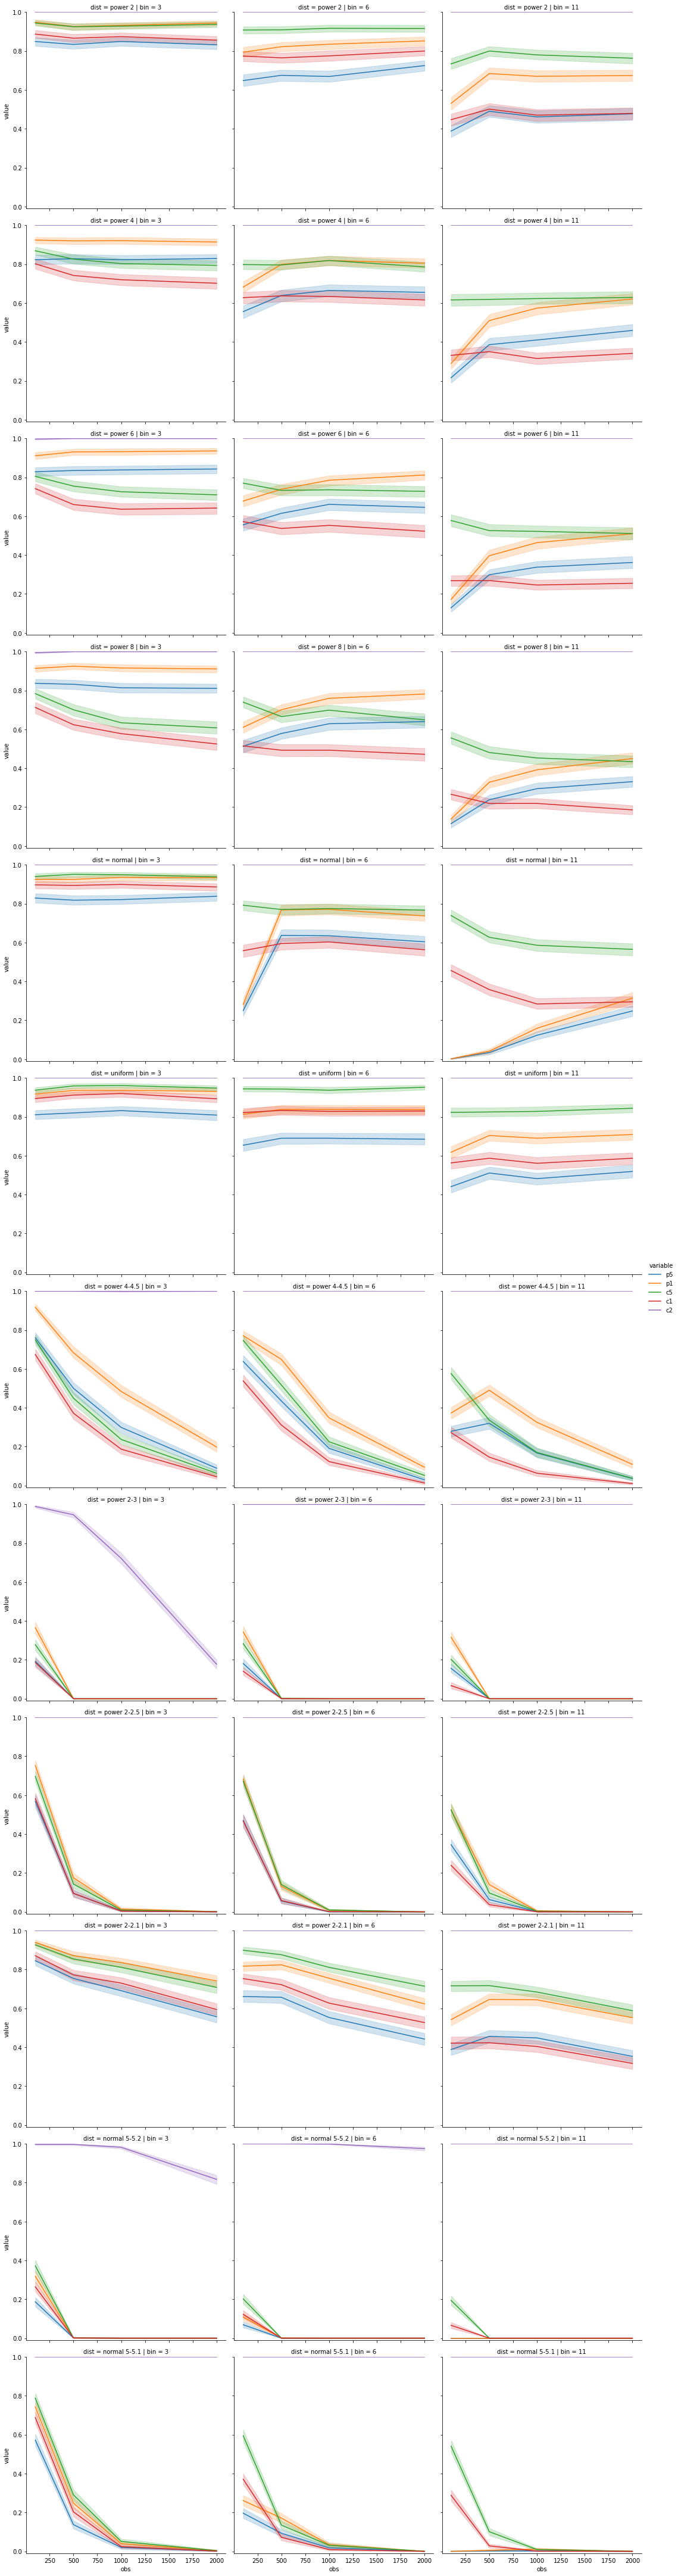

In [513]:
multiple = pd.DataFrame(gen_data(CASES, [2,5,10], [100, 500, 1000, 2000], trials=1000, ensembles=20))
relplot(tf_transform(multiple))

In [ ]:
# Standardise 
MAX = 20
ENSEMBLES = 2

def gen_ee(func, obs, binr):
    data = []
    for i in range(ENSEMBLES):
        row = func(i, obs)
        data.append(row)
    data = np.array(data)
    o = max(binr,3)
    bins = np.linspace(int(np.floor(data.min())), int(np.ceil(data.max())), o)
    ee = ErgodicEnsemble(observations=data, bins=bins)
    return ee

In [ ]:
# first version of analysis

cases = {
    "power 2": lambda i, o: np.random.power(2,o)*MAX,
    "power 4": lambda i, o: np.random.power(4,o)*MAX,
    "power 6": lambda i, o: np.random.power(6,o)*MAX,
    "power 8": lambda i, o: np.random.power(8,o)*MAX,
    "normal": lambda i, o: np.random.normal(MAX, 0.5, o),
    "uniform": lambda i, o: np.random.uniform(0, MAX, o),
    "power 4-4.5": lambda i, o: np.random.power(4 if i == 1 else 4.5,o)*MAX,
    "power 2-3": lambda i, o: np.random.power(2 if i == 1 else 3,o)*MAX,
    "power 2-2.5": lambda i, o: np.random.power(2 if i == 1 else 2.5,o)*MAX,
    "normal 5-5.2": lambda i, o: np.random.normal(5 if i == 1 else 5.2, 0.5, o),
    "normal 5-5.1": lambda i, o: np.random.normal(5 if i == 1 else 5.1, 0.5, o),
}

lax = {
    #"1": lambda ee: ee.complexity < 0.01,
    #"8": lambda ee: ee.complexity < 0.8/ee.obs_counts[1],
    #"7": lambda ee: ee.complexity < 0.7/ee.obs_counts[1],
    #"9": lambda ee: ee.complexity < 0.9/ee.obs_counts[1],
    #"1": lambda ee: ee.complexity < 1/ee.obs_counts[1],
    #"3": lambda ee: ee.complexity < 0.05/(ee.obs_counts[1]**0.5),
    "0.1*": lambda ee: ee.complexity < 0.1/(ee.obs_counts[1]**0.5),
    "0.05*": lambda ee: ee.complexity < 0.05/(ee.obs_counts[1]**0.5),
    "0.08*": lambda ee: ee.complexity < 0.08/(ee.obs_counts[1]**0.5),
    "0.07*": lambda ee: ee.complexity < 0.07/(ee.obs_counts[1]**0.5),
    "0.01*": lambda ee: ee.complexity < 0.01/(ee.obs_counts[1]**0.25),
    "0.02*": lambda ee: ee.complexity < 0.05/(ee.obs_counts[1]**0.25),
    "0.03*": lambda ee: ee.complexity < 0.1/(ee.obs_counts[1]**0.25),
    #"5": lambda ee: ee.complexity < 0.2/(ee.obs_counts[1]**0.5),
    #"6": lambda ee: ee.complexity < 0.01/(ee.obs_counts[1]**0.25),
}

def analyse_chi(ee):
    lobs = len(ee.histograms[0])
    ones = np.ones(len(ee.histograms[0]))
    _, p = chisquare(ee.histograms[0]+ones, ee.histograms[1]+ones)
    laxness = 0.08/(ee.obs_counts[1]**0.5)
    
    results = [1 if p > 0.05 else 0]
    for lfunc in lax.values():
        results.append(1 if lfunc(ee) else 0)
    return results


def run_mass(binr):
    data = []
    for OBS in [100, 500, 1000, 2000]:
        runs = {}
        for k in cases.keys():
            runs['%s_p' % k] = []
            for l in lax.keys():
                runs['%s_%s' % (k,l)] = []
        
        trials = 1000
        for i in range(trials):
            nbsetup.cp(binr, OBS, i)
            for k, func in cases.items():
                results = analyse_chi(gen_ee(func, OBS, binr))
                runs['%s_p' % k].append(results[0])
                for j, lk in enumerate(lax.keys()):
                    runs['%s_%s' % (k,lk)].append(results[j+1])
        
        app = {"OBS": OBS}
        for k, v in runs.items():
            app[k] = sum(v)/trials
        data.append(app)
    return pd.DataFrame(data)


bins = [2, 5, 10]
fig, axes = plt.subplots(len(bins), len(cases.keys()), sharex=True, sharey=True, figsize=(15,10))

for d, b in enumerate(bins):
    df = run_mass(b)
    for i, k in enumerate(cases.keys()):
        cols = ['OBS', '%s_p' % k]
        for l in lax.keys():
            cols.append('%s_%s' % (k, l))
        melt = df.loc[:, cols].melt(id_vars="OBS")
        
        axes[d][i].set_title(k)
        axes[d][i].set(ylim=(-0.1,1.1))
        
        legend = i == 0 and d == 0
        sns.lineplot(data=melt, x="OBS", y="value", hue="variable", palette="rainbow", ax=axes[d][i], legend=legend)



In [ ]:
# ergodic demonstration a la Ole Peters
# https://www.youtube.com/watch?v=LGqOH3sYmQA

ensembles = 1
timesteps = 100

data = {'x': np.arange(timesteps+1)}
for i in range(ensembles):
    series = [100]
    for t in range(timesteps):
        if np.random.choice([True, False]):
            s = series[t]*1.5
        else:
            s = series[t]*0.6
        series.append(s)
    data[i] = np.array(series)

df = pd.DataFrame(data)
g = sns.lineplot(x='x', y='value', ci=None, hue='variable', data=df.melt(id_vars=['x']), legend=0)
g.set(yscale='log')

In [295]:
# custom relplot (not only here for reference)



def plot(data, dists=None):
    # setup subplots
    bin_range = data['bin'].unique()
    obs_range = data['obs'].unique()
    if dists == None:
        dists = data['dist'].unique()
    fig, axes = plt.subplots(len(bin_range), len(dists), sharex=True, sharey=True, figsize=(15,10))
    
    # bins per row
    for bi, b in enumerate(bin_range):
        # distributions per column
        for di, d in enumerate(dists):
            # observations on x
            gtemp = []
            for o in obs_range:
                nbsetup.cp(b, d, o)
                filt = data.loc[(data['bin'] == b) & (data['dist'] == d) & (data['obs'] == o)]
                
                # analysis
                analysis = {'obs': o}
                for _, r in filt.iterrows():
                    appnd(analysis, 'p5', 1 if r['p'] > 0.05 else 0)
                    appnd(analysis, 'p1', 1 if r['p'] > 0.01 else 0)
                    
                    # c = (1-r['c'])*(o**0.5)/(2*b**0.1)
                    # does alright
                    
                    # insanely close to p5 for low bins
                    x = (1-r['c']) < 1.5/o
                    #appnd(analysis, 'c5-1.5', 1 if x else 0)
                    x = (1-r['c']) < 2/o
                    appnd(analysis, 'c5-2', 1 if x else 0)
                    
                    x = (1-r['c']) < 1.4/o
                    appnd(analysis, 'c1', 1 if x else 0)
                    
                    
                    
                    # simulating degrees of freedom
                    x = (1-r['c']) < 0.0005*(b-1)
                    #appnd(analysis, 'cb', 1 if x else 0)
                    
                    #c = c*0.5
                    #appnd(analysis, 'c5b', 1 if c < 0.05 else 0)
                    #appnd(analysis, 'c1b', 1 if c < 0.01 else 0)
                    
                    #c = c/(b**0.5)
                    #appnd(analysis, 'c5c', 1 if c < 0.05 else 0)
                    #appnd(analysis, 'c1c', 1 if c < 0.01 else 0)
                    
                    #c = c*0.9
                    #appnd(analysis, 'c5c', 1 if c < 0.05 else 0)
                    #appnd(analysis, 'c1c', 1 if c < 0.01 else 0)
                    
                    #c = (1-r['c'])*4
                    #appnd(analysis, 'c5-', 1 if c < 0.05 else 0)
                    #appnd(analysis, 'c1-', 1 if c < 0.01 else 0)
                    
                    #c = (1-r['c'])*80000/(o**2)
                    #appnd(analysis, 'c5d', 1 if c < 0.05 else 0)
                    #appnd(analysis, 'c1d', 1 if c < 0.01 else 0)
                    
                    #c = (1-r['c'])*80000/(o**4)
                    #appnd(analysis, 'c5e', 1 if c < 0.05 else 0)
                    #appnd(analysis, 'c1e', 1 if c < 0.01 else 0)
                
                # reset to mean values
                for k, v in analysis.items():
                    if k != 'obs':
                        analysis[k] = sum(analysis[k])/len(analysis[k])
                
                gtemp.append(analysis)
            
            gframe = pd.DataFrame(gtemp)
            # titles
            axes[bi][di].set_title(d)
            axes[bi][di].set(ylim=(-0.1,1.1))
            
            # only show legend on first one
            legend = bi == 0 and di == 0
            sns.lineplot(data=gframe.melt(id_vars='obs'), x="obs", y="value", hue="variable", palette="rainbow", ax=axes[bi][di], legend=legend)



10 normal 5-5.2 2000


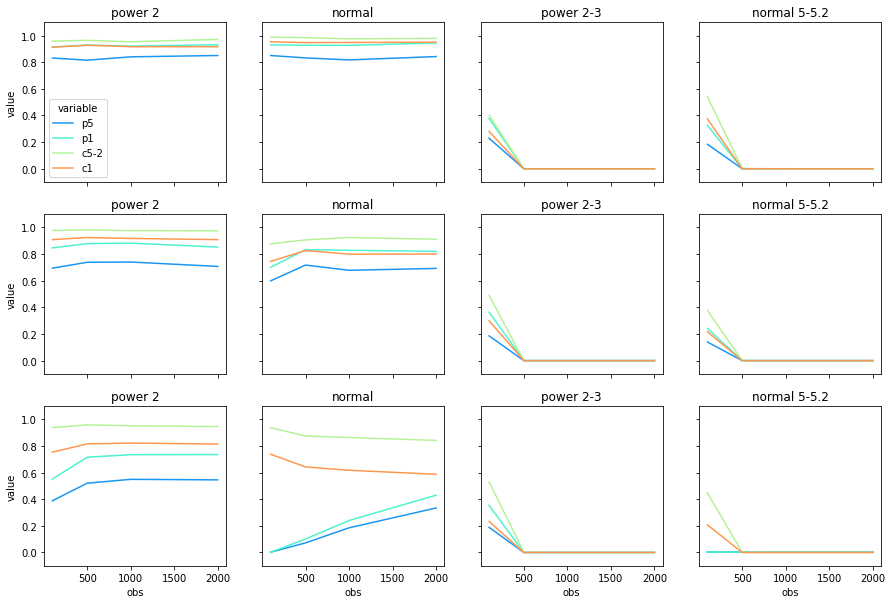

In [297]:
%%time
plot(df, ['power 2', 'normal', 'power 2-3', 'normal 5-5.2'])